# Example 4 - Ferry Service with Random Demand



Let's make life easy for this one and assume the following set up:


- A ferry (or whatever) has remaining capacity S (not C, because remaining capacity is our state variable).
- Each period, the operator can set a price to sell space at.
- The ferry faces a fixed deterministic demand given by

$$q = A e^{-kp} + \varepsilon$$

$$\varepsilon \sim N(0, \sigma^{2})$$

- In a given period, the operator sets price and realizes demand. The remaining capacity they take into next period is

$$ s^{\prime} = \max\{ s - q, 0\} $$

That is, if they can't satisfy demand with the remaining space they sell nothing.

- The period payoff is 

$$ p (s - s^{\prime}) $$

## Libraries

In [1]:
import numpy as np
import pandas as pd

from markov_decision_process import TimeAugmentedMDP
from markov_decision_process.utilities import discretize_normal

from rich import print
from rich.pretty import pprint

from catboost import CatBoostClassifier

# Import isotonic regression
from sklearn.isotonic import IsotonicRegression

from scipy.stats import norm as normal

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette("deep")
%matplotlib inline

import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

## Parameters

Same parameters as example 3, except now we add a shock to demand.

In [2]:
# Same parameters as before

max_capacity: float = 100
S: list[float] = np.linspace(0, max_capacity, 201).tolist()
A: list[float] = np.linspace(1, 100, 51).tolist()
T: list[int] = np.arange(-30, 1).tolist()

In [3]:
# Changing the contstant A to C here because we use A for the action space
C = 10
K = 0.05
sigma = 0.001


def demand(price):
    # Let demand be linear in price
    # It can't be less than 0
    # q = 10 - .15*price
    q = C * np.exp(-K * price) + np.random.normal(0, sigma)

    # Round q to the nearest half
    q = np.round(q)

    # Demand can't be negative

    return np.clip(q, 0, None)

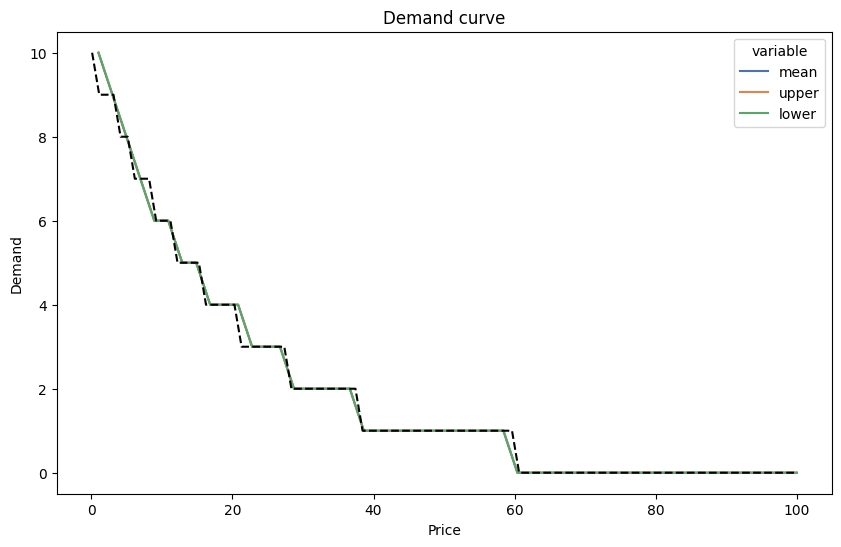

In [4]:
# Plot the demand curve

# Generate a data frame 20000 rows with random prices
prices = np.random.choice(A, 100000)
df = pd.DataFrame({"price": prices})

# Apply to each row
df["demand"] = df["price"].apply(demand)

# Group by price, find mean and standard deviation
df = (
    df.groupby("price")
    .agg(mean=("demand", "mean"), std=("demand", "std"))
    .reset_index()
)

## Make lines for 2std above and below the mean
df["upper"] = df["mean"] + 2 * df["std"]
df["lower"] = np.clip(df["mean"] - 2 * df["std"], 0, None)

# Melt the data frame
df = df.melt(
    id_vars="price", value_vars=["mean", "upper", "lower"], value_name="demand"
)


# Now generate the expected demand curve
x = np.linspace(1e-1, 100, 100)
expected_demand = np.round(C * np.exp(-K * x))

# Plot the demand curve
plt.figure(figsize=(10, 6))

sns.lineplot(data=df, x="price", y="demand", hue="variable")

# Plot expected demand as dashed line
plt.plot(x, expected_demand, "k--")

plt.title("Demand curve")
plt.xlabel("Price")
plt.ylabel("Demand")

plt.show()

### ML Model for Demand

First we create a bunch of training data from the demand process. 

Next we make the target variable which state would be transitioned to for a given choice of price, as a categorical variable.

Train a multiclass classification model to predict the probability that a service will move to state $s^{\prime}$ given they're in state $s$ and choose price $p$.

In [5]:
# Make a data frame where we have 100,000 rows where we have columns
# s, t, a, each a random choice from the lists S, T, A.

n = 100_000
df = pd.DataFrame(
    {
        "s": np.random.choice(S, n),
        "t": np.random.choice(T, n),
        "a": np.random.choice(A, n),
    }
)

# Now compute demand
df["q"] = df.apply(lambda row: demand(row["a"]), axis=1)

# Now compute s_prime
df["s_prime"] = np.clip(df["s"] - df["q"], 0, None)

df["s_prime"] = pd.Categorical(df["s_prime"], categories=S)

In [ ]:
from sklearn.model_selection import train_test_split

# Assuming `self.data` is your DataFrame
train_data, test_data = train_test_split(df, test_size=0.2, random_state=2718)

TARGET = "s_prime"
FEATURES = ["s", "t", "a"]

X_train = train_data[FEATURES]
y_train = train_data[TARGET]
X_test = test_data[FEATURES]
y_test = test_data[TARGET]


params = {
    "iterations": 2000,
    "loss_function": "MultiClass",
    "verbose": 50,
    "snapshot_file": f"/tmp/catboost_snapshot_{sigma}.cbm",
    "early_stopping_rounds": 20,
    "use_best_model": True,
    "task_type": "GPU",
    "save_snapshot": True,
    "snapshot_interval": 2,
    "train_dir": "../../models/catboost_info_sigma_{sigma}",
}


# Now you can use `train_data` for training and `test_data` for testing
model = CatBoostClassifier(**params)

# Fit the model
model.fit(X_train, y_train, eval_set=(X_test, y_test))

# Save the model
fname = f"../../models/model_{params['iterations']}_sigma_{sigma}.cbm"
model.save_model(fname)

Learning rate set to 0.120919
0:	learn: 4.8046852	test: 4.8089695	best: 4.8089695 (0)	total: 303ms	remaining: 10m 6s
50:	learn: 2.3784363	test: 2.3959801	best: 2.3959801 (50)	total: 14.8s	remaining: 9m 26s
100:	learn: 1.9067648	test: 1.9261387	best: 1.9261387 (100)	total: 29.5s	remaining: 9m 14s
150:	learn: 1.6637934	test: 1.6850477	best: 1.6850477 (150)	total: 44.2s	remaining: 9m
200:	learn: 1.4887852	test: 1.5158109	best: 1.5158109 (200)	total: 59s	remaining: 8m 47s
250:	learn: 1.3650678	test: 1.3974813	best: 1.3974813 (250)	total: 1m 13s	remaining: 8m 34s
300:	learn: 1.2664785	test: 1.3073753	best: 1.3073753 (300)	total: 1m 28s	remaining: 8m 22s
350:	learn: 1.1822030	test: 1.2288274	best: 1.2288274 (350)	total: 1m 44s	remaining: 8m 8s
400:	learn: 1.1103807	test: 1.1656351	best: 1.1656351 (400)	total: 1m 59s	remaining: 7m 55s
450:	learn: 1.0531096	test: 1.1134001	best: 1.1134001 (450)	total: 2m 14s	remaining: 7m 41s
500:	learn: 1.0073366	test: 1.0756001	best: 1.0756001 (500)	total: 2

#### Pick a random state and compare estimated density to actual density

Prediction shape: (1, 201)

Prediction sum across rows: [1.]

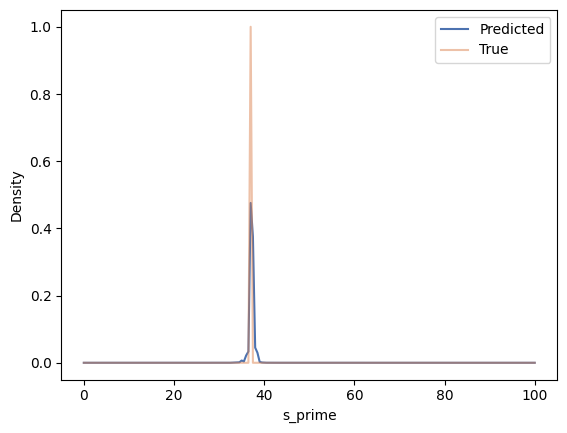

In [7]:
s = np.random.choice(S)
a = np.random.choice(A)
t = np.random.choice(T)

row = pd.DataFrame({"s": [s], "t": [-10], "a": [a]})
pred = model.predict_proba(row[FEATURES])
# pred = nb_model.predict_proba(row[FEATURES])

mu = s - C * np.exp(-K * a)
true_dist = discretize_normal(S, mu, sigma)

print(f"Prediction shape: {pred.shape}")
print(f"Prediction sum across rows: {pred.sum(axis=1)}")

# So note that we get a probabilite that the next state is each of the states in S
# Sometimes this may not sum exatlly to 1 because of floating point errors
# But the MDP package will normalize it.

# Let's plot this distribution
fig, ax = plt.subplots()
sns.lineplot(x=S, y=pred.flatten(), ax=ax, label="Predicted")
sns.lineplot(x=S, y=true_dist, ax=ax, alpha=0.5, label="True")

plt.xlabel("s_prime")
plt.ylabel("Density")

plt.show()

In [8]:
# Pretty damn accurate!

### Problem Setup

In [9]:
class MDPProblem(TimeAugmentedMDP):
    def __init__(self, S, A, T):
        super().__init__()

        self.S: list[float] = S

        self.A: list[float] = A

        self.T: list[int] = T

        return None

    def reward(
        self,
        s_prime: float,
        s: float,
        t: int,
        a: float,
    ) -> float:
        return a * (s - s_prime)

In [10]:
%%time
mdp = MDPProblem(S, A, T)
mdp.solve_model(model)

INFO:markov_decision_process.time_augmented_mdp:State space augmented with time
/home/rob/Markov-Decision-Process-Toolkit/src/markov_decision_process/time_augmented_mdp.py:469: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_a.loc[:, 'reward'] = self.reward(df_a['s_prime'], df_a['s'], df_a['t'], df_a['a'])
/home/rob/Markov-Decision-Process-Toolkit/src/markov_decision_process/time_augmented_mdp.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "s_augmented_index"] = df.apply(
/home/rob/Markov-

INFO:markov_decision_process.time_augmented_mdp:MDP solved


CPU times: user 2min 24s, sys: 11.7 s, total: 2min 36s
Wall time: 1min 50s


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


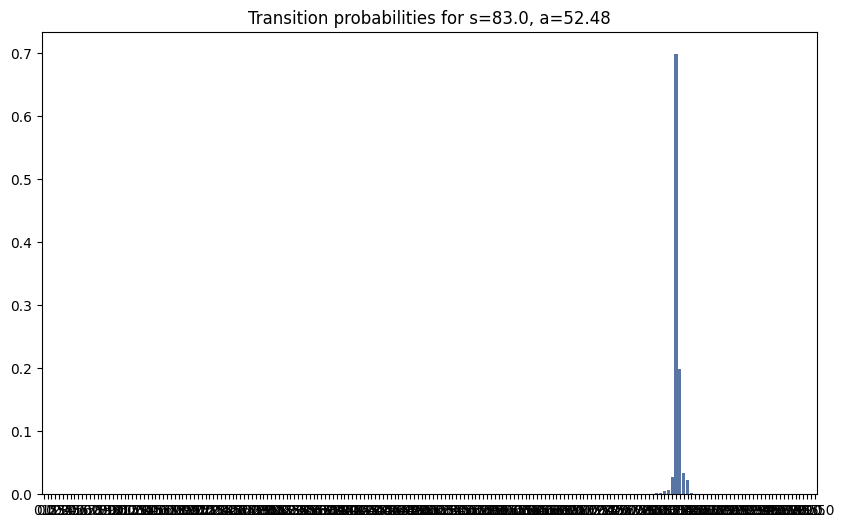

In [11]:
# Get transitions for state 50 and action 5

# Pick a random s in the state space
s = np.random.choice(mdp.S)

# Pick a random action
a = np.random.choice(mdp.A)
a_ix = mdp.A.index(a)

t = -30

transitions = mdp.get_transition_probabilties(s, t, a)

x = transitions["next_states"]
y = transitions["probabilities"]

plt.figure(figsize=(10, 6))

sns.barplot(x=x, y=y)

plt.title(f"Transition probabilities for s={s}, a={a}")

plt.show()

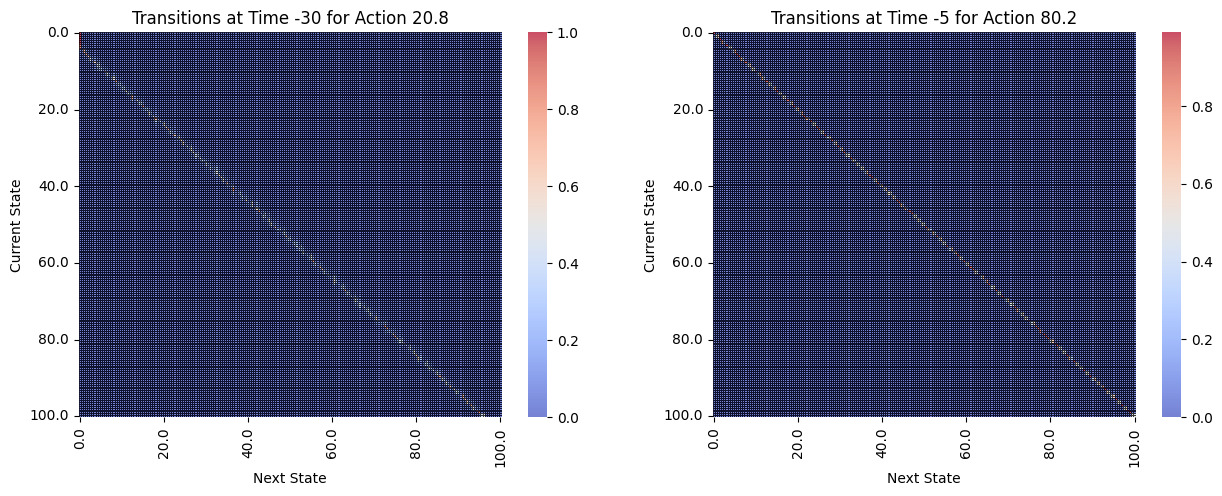

In [12]:
# Plot the transitions at time -30

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Pick out actions near 20.8 and 80.2
a0 = np.where(np.isclose(mdp.A, 20.8))[0][0]
a1 = np.where(np.isclose(mdp.A, 80.2))[0][0]

mdp.plot_matrix(
    matrix_type="transitions",
    t=-30,
    a=mdp.A[a0],
    ax=ax[0],
)

mdp.plot_matrix(
    matrix_type="transitions",
    t=-5,
    a=mdp.A[a1],
    ax=ax[1],
)

plt.show()

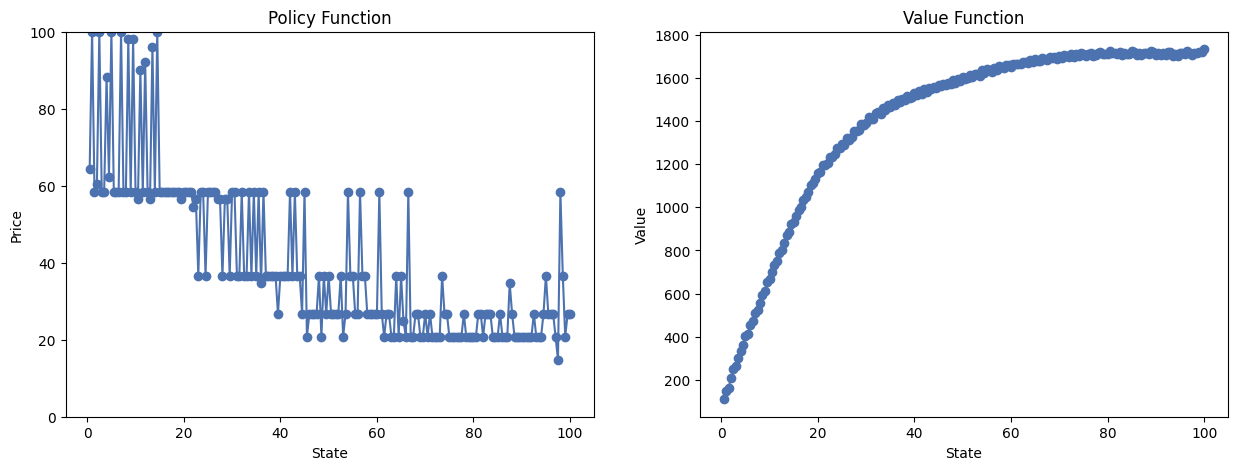

In [13]:
# Plot the optimal policy

period = -20

x = mdp.policy_function[period].keys()
policy = mdp.policy_function[period].values()
value = mdp.value_function[period].values()

# Remove state 0
x = list(x)[1:]
policy = list(policy)[1:]
value = list(value)[1:]


fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].scatter(x, policy)
ax[0].plot(x, policy)
ax[0].set_title("Policy Function")
ax[0].set_xlabel("State")
ax[0].set_ylabel("Price")
ax[0].set_ylim(0, 100)

ax[1].scatter(x, value)
ax[1].plot(x, value)
ax[1].set_title("Value Function")
ax[1].set_xlabel("State")
ax[1].set_ylabel("Value")

plt.show()

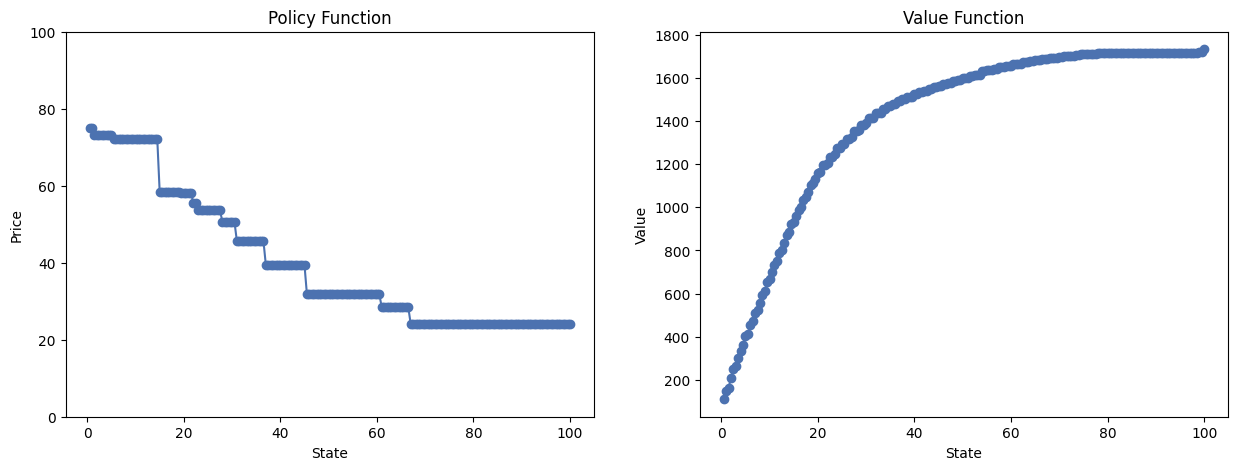

In [14]:
# Apply isotonic regression to both

x = mdp.policy_function[period].keys()
policy = mdp.policy_function[period].values()
value = mdp.value_function[period].values()

# policy should be non-increasing in state,
# value should be non-decreasing in state

policy = IsotonicRegression(increasing=False).fit_transform(
    np.array(list(x)), np.array(list(policy))
)
value = IsotonicRegression().fit_transform(
    np.array(list(x)), np.array(list(value))
)

# Plot the optimal policy

period = -20


# Remove state 0
x = list(x)[1:]
policy = list(policy)[1:]
value = list(value)[1:]


fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].scatter(x, policy)
ax[0].plot(x, policy)
ax[0].set_title("Policy Function")
ax[0].set_xlabel("State")
ax[0].set_ylabel("Price")
ax[0].set_ylim(0, 100)

ax[1].scatter(x, value)
ax[1].plot(x, value)
ax[1].set_title("Value Function")
ax[1].set_xlabel("State")
ax[1].set_ylabel("Value")

plt.show()

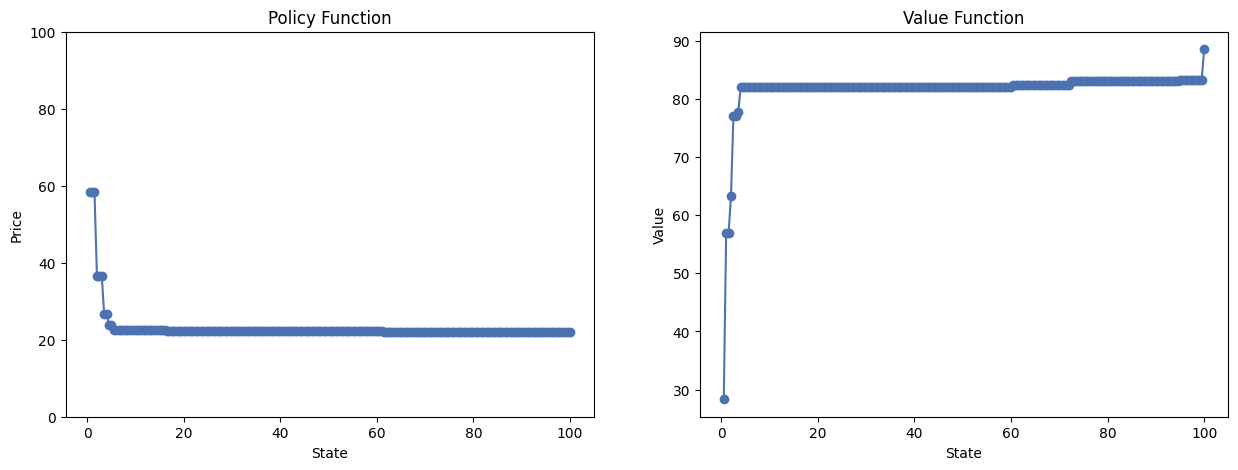

In [15]:
period = max(mdp.T) - 1

x = mdp.policy_function[period].keys()
policy = mdp.policy_function[period].values()
value = mdp.value_function[period].values()

# Remove state 0
x = list(x)[1:]
policy = list(policy)[1:]
value = list(value)[1:]

policy = IsotonicRegression(increasing=False).fit_transform(
    np.array(list(x)), np.array(list(policy))
)
value = IsotonicRegression().fit_transform(
    np.array(list(x)), np.array(list(value))
)


fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].scatter(x, policy)
ax[0].plot(x, policy)
ax[0].set_title("Policy Function")
ax[0].set_xlabel("State")
ax[0].set_ylabel("Price")
ax[0].set_ylim(0, 100)

ax[1].scatter(x, value)
ax[1].plot(x, value)
ax[1].set_title("Value Function")
ax[1].set_xlabel("State")
ax[1].set_ylabel("Value")

plt.show()